<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/03-23-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US: {res.positive/us_pop*100:2f}%")

positive     51970
negative    292758
pending      14433
total       359161
dtype: int64
Current Infection Rate 14.469834%
Percentage of US: 0.015750%


In [7]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,25665,65605
34,NJ,3675,8325
52,WA,2221,31712
5,CA,2102,13452
24,MI,1791,2069
16,IL,1551,9934
10,FL,1412,13127
20,LA,1388,7215
21,MA,1159,12590
11,GA,1026,4458


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [9]:
dfUSAPos[-7:]

,date,positive,PCT
14,20200318,7731,0.148759
15,20200319,11723,0.225572
16,20200320,17038,0.327843
17,20200321,23203,0.446469
18,20200322,31888,0.613585
19,20200323,42164,0.811314
20,20200324,51970,1.000000


In [10]:
dfCAPos[-7:]

,date,positive,PCT
14,20200318,611,0.290676
15,20200319,924,0.439581
16,20200320,1063,0.505709
17,20200321,1279,0.608468
18,20200322,1536,0.730733
19,20200323,1733,0.824453
20,20200324,2102,1.000000


In [11]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total
date,,,,,,
20200320,17038,118147,3336,0.0,219,138521
20200321,23203,155909,3477,1964.0,272,182589
20200322,31888,193463,2842,2554.0,398,228216
20200323,42164,237321,14571,3325.0,471,294056
20200324,51970,292758,14433,4468.0,675,359161


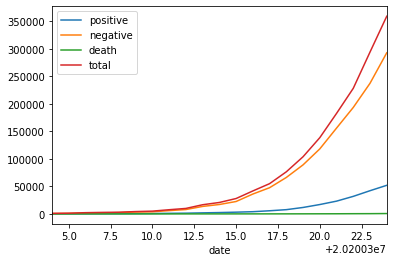

In [12]:
gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200311,696,25
20200312,987,29
20200313,1264,36
20200314,1678,41
20200315,1678,41
20200316,1678,41
20200317,3503,58
20200318,3536,58
20200319,7087,100


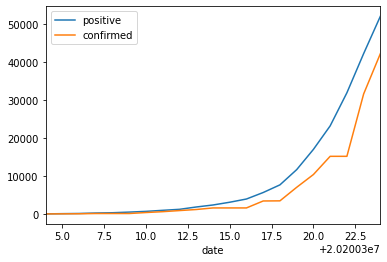

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalized,death,total
date,,,,,,
20200318,611,7981,0,0.0,13,8592
20200319,924,8787,0,0.0,18,9711
20200320,1063,10424,0,0.0,20,11487
20200321,1279,11249,0,0.0,24,12528
20200322,1536,11304,0,0.0,27,12840
20200323,1733,12567,12100,0.0,27,26400
20200324,2102,13452,12100,0.0,40,27654


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    43667
dead           552
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    2108
dead           39
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
China             81496
Italy             63927
US                43667
Spain             35136
Germany           29056
Iran              23049
France            20123
Korea, South       8961
Switzerland        8795
United Kingdom     6726
Name: confirmed, dtype: int64

In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
China             81496
Italy             63927
US                43667
Spain             35136
Germany           29056
Iran              23049
France            20123
Korea, South       8961
Switzerland        8795
United Kingdom     6726
Netherlands        4764
Austria            4474
Belgium            3743
Norway             2621
Canada             2088
Portugal           2060
Sweden             2046
Brazil             1924
Australia          1682
Denmark            1572
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [25]:
dfState.loc['NY'].head(7)

,date,positive,current_total,pct
state,,,,
NY,20200324,25665,25665,1.000000
NY,20200323,20875,25665,0.813365
NY,20200322,15168,25665,0.590999
NY,20200321,10356,25665,0.403507
NY,20200320,7102,25665,0.276719
NY,20200319,4152,25665,0.161777
NY,20200318,2382,25665,0.092811


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

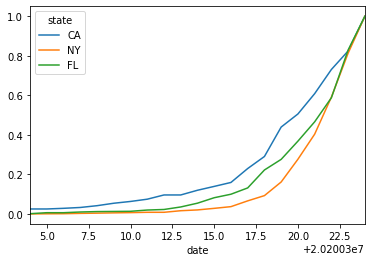

In [27]:
x = res.loc[:, ['CA','NY','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

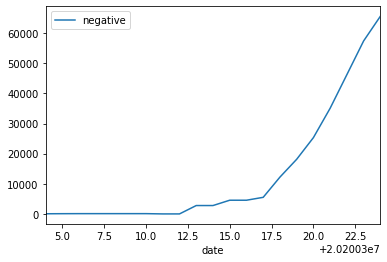

In [29]:
x = dfNYTesting.plot.line()

In [30]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,current_total,pct
205,GA,20200324,1026,1026,1.000000
206,GA,20200323,772,1026,0.752437
207,GA,20200322,600,1026,0.584795
208,GA,20200321,507,1026,0.494152
209,GA,20200320,420,1026,0.409357
210,GA,20200319,287,1026,0.279727
211,GA,20200318,197,1026,0.192008
212,GA,20200317,146,1026,0.142300
213,GA,20200316,121,1026,0.117934
214,GA,20200315,99,1026,0.096491


In [33]:
datecutoff = int(((pd.to_datetime(str(dfDates.date.max())))-datetime.timedelta(days=2)).strftime("%Y%m%d"))
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .60)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
688,NY,20200322,15168,25665,0.590999
629,NJ,20200322,1914,3675,0.520816
447,MI,20200322,1035,1791,0.577889
186,FL,20200322,830,1412,0.587819
388,MA,20200322,646,1159,0.557377
207,GA,20200322,600,1026,0.584795
768,PA,20200322,479,851,0.562867
129,CT,20200322,223,618,0.360841
313,IN,20200322,201,365,0.550685
67,AZ,20200322,152,357,0.425770
